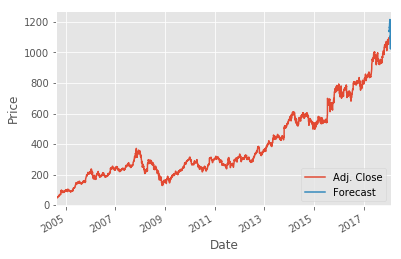

In [4]:
import math
import datetime

import quandl
import numpy as np
import pandas as pd
from matplotlib import style
import matplotlib.pyplot as plt
from sklearn import preprocessing, cross_validation
from sklearn.linear_model import LinearRegression


style.use('ggplot')

data_frame = quandl.get('WIKI/GOOGL')
data_frame = data_frame[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
data_frame['HL_PCT'] = (data_frame['Adj. High'] - data_frame['Adj. Low']) / data_frame['Adj. Low'] * 100
data_frame['PCT_change'] = (data_frame['Adj. Close'] - data_frame['Adj. Open']) / data_frame['Adj. Open'] * 100

data_frame = data_frame[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

forecast_column = 'Adj. Close'
data_frame.fillna(-99999, inplace=True)
forecast_output = int(math.ceil(0.01 * len(data_frame)))

data_frame['label'] = data_frame[forecast_column].shift(-forecast_output)

X = np.array(data_frame.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_output:]
X = X[:-forecast_output]

data_frame.dropna(inplace=True)
y = np.array(data_frame['label'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

classifier = LinearRegression()
classifier.fit(X_train, y_train)
accuracy = classifier.score(X_test, y_test)

forecast_set = classifier.predict(X_lately)

data_frame['Forecast'] = np.nan
last_date = data_frame.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    data_frame.loc[next_date] = [np.nan for _ in range(len(data_frame.columns) - 1)] + [i]

data_frame['Adj. Close'].plot()
data_frame['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
